# Parsing and saving the expert-rated dataset

## Imports

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import json
import random
from scipy.stats import spearmanr
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import asyncio
import nest_asyncio
nest_asyncio.apply()

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import pubmetric.network as nw
import pubmetric.pckg_dev as dev
import pubmetric.metrics as met

from style import palette as palette

# Rated workflows dataset 

## Load dataset

In [4]:
# LOAD files 

with open('../data/test_rated.json', 'r') as json_file:
    test_set = json.load(json_file)

print(len(test_set))
print(test_set[0]) # one workflow

with open('../data/train_rated.json', 'r') as json_file:
    train_set = json.load(json_file)

print(len(train_set))
print(train_set[0]) # one workflow

all_rated_data = train_set + test_set

63
{'ratingAvg': 0.0, 'expert1': 0.0, 'expert2': 0.0, 'workflow': [['DeconTools', 'TDimpute']], 'pmid_workflow': [['10757168', None]], 'usecase': 3, 'scenario': 'Full ', 'id': 363, 'rating_bin': '0'}
250
{'ratingAvg': 0.5, 'expert1': 0.0, 'expert2': 1.0, 'workflow': [['msConvert', 'Comet'], ['Comet', 'ProteinProphet'], ['ProteinProphet', 'PeptideProphet']], 'pmid_workflow': [['23051804', '23148064'], ['23148064', '14632076'], ['14632076', '12403597']], 'usecase': 2, 'scenario': 'Original ', 'id': 177, 'rating_bin': '0-1'}


## Expert rated data stats

In [ ]:
expert_ratings = [workflow['ratingAvg'] for workflow in all_rated_data]

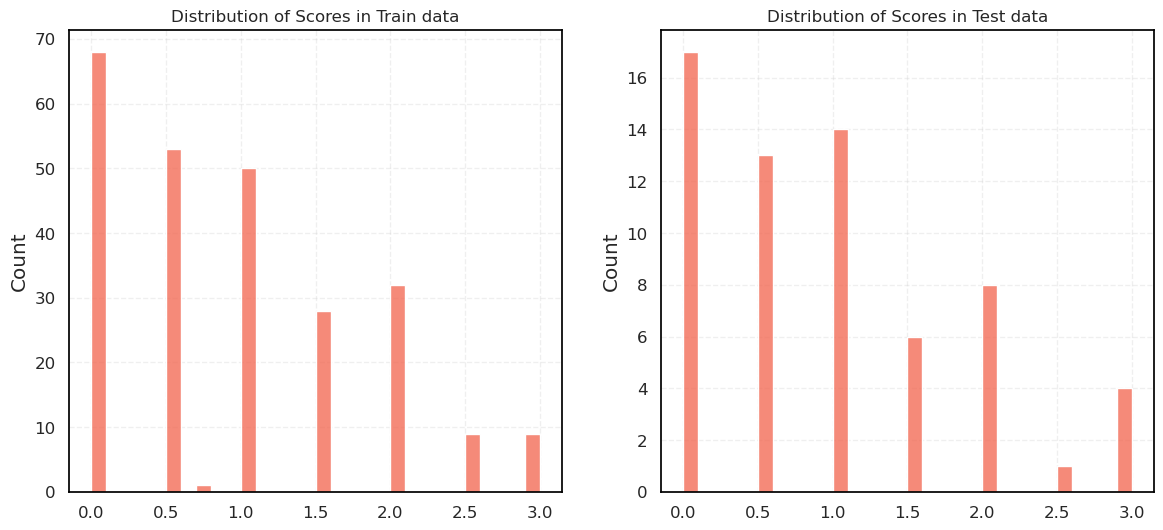

In [ ]:
train_ratings = [workflow['ratingAvg'] for workflow in train_set]
test_ratings = [ item['ratingAvg'] for item in test_set]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(train_ratings, bins=30, ax=axes[0])
axes[0].set_title("Distribution of Scores in Train data")

sns.histplot(test_ratings, bins=30, ax=axes[1])
axes[1].set_title("Distribution of Scores in Test data")

plt.show()


226


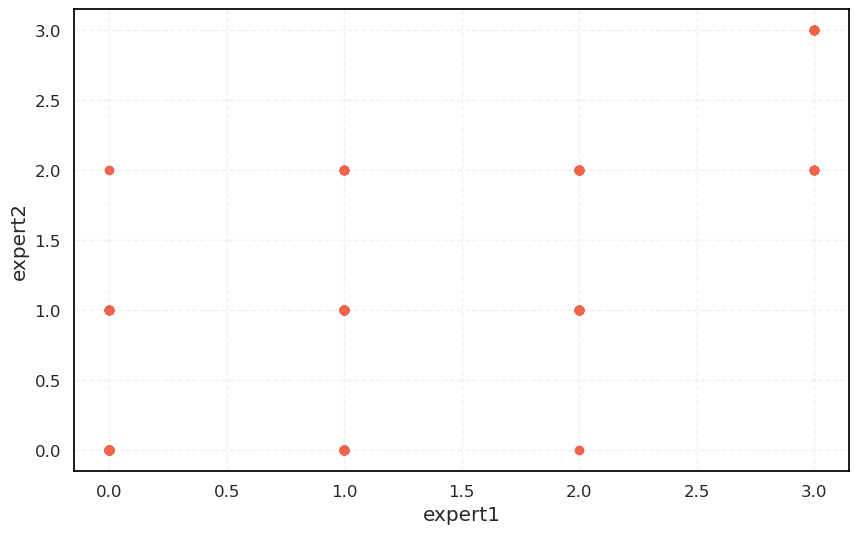

In [ ]:
expert1_ratings = [workflow['expert1'] for workflow in all_rated_data if 'expert1' in workflow]
expert2_ratings = [workflow['expert2'] for workflow in all_rated_data if 'expert2' in workflow]
print(len(expert1_ratings))
plt.scatter(expert1_ratings, expert2_ratings)

plt.xlabel('expert1')
plt.ylabel('expert2')
plt.show()



Spearman's correlation coefficient: 0.7538832711871502
P-value: 9.626390946748715e-43
Expert 1 mean 1.0398230088495575 and median 1.0
Expert 2 mean 0.8407079646017699 and median 1.0


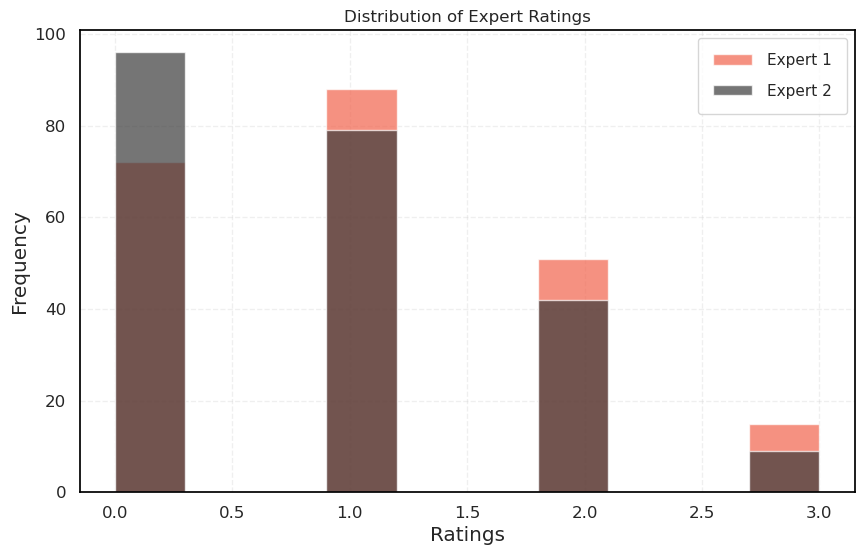

In [ ]:
# Spearman's correlation coefficient
correlation, p_value = spearmanr(expert1_ratings, expert2_ratings)

print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")
print("Expert 1 mean", np.mean(expert1_ratings), "and median", np.median(expert1_ratings))
print("Expert 2 mean", np.mean(expert2_ratings), "and median", np.median(expert2_ratings))

plt.hist(expert1_ratings, bins=10, alpha=0.7, color=palette[0], label='Expert 1')
plt.hist(expert2_ratings, bins=10, alpha=0.7, color=palette[1], label='Expert 2')
plt.title(f'Distribution of Expert Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

/tmp/ipykernel_60642/3986294867.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tool', y='Count', data=df, palette=red_palette)


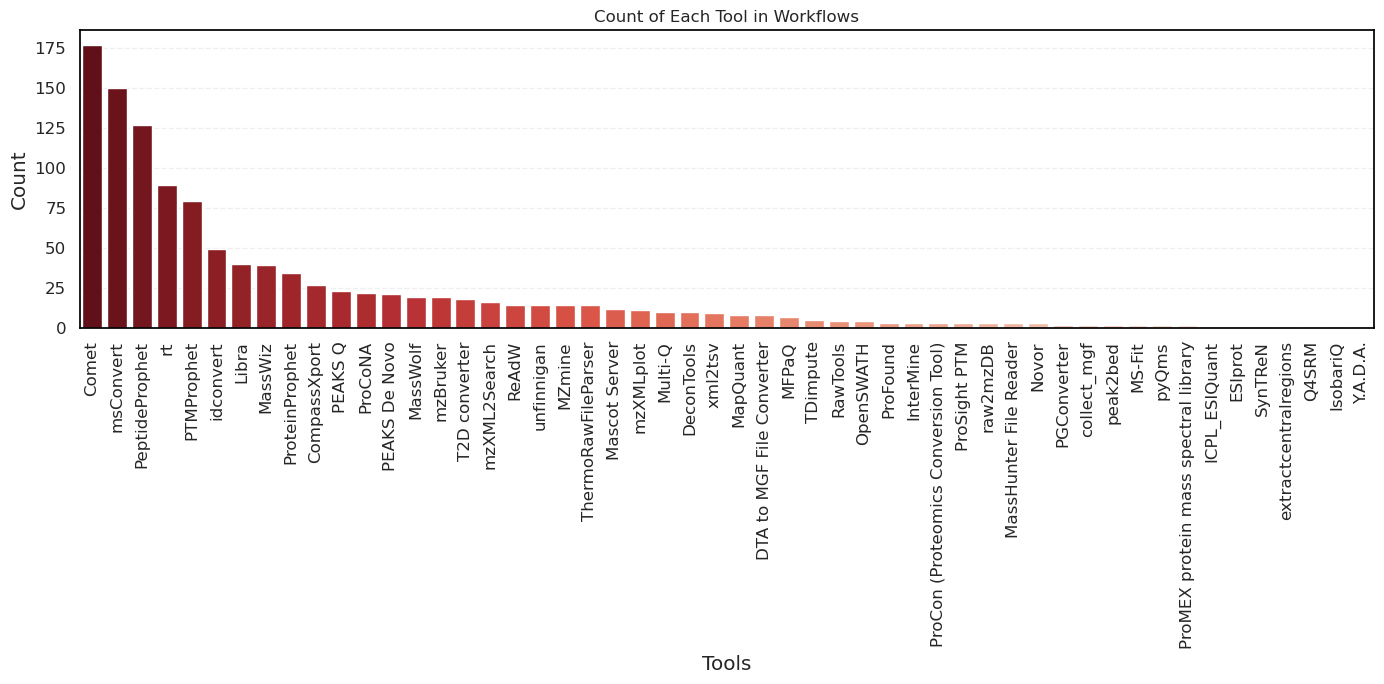

In [37]:
# Function to count tools
def count_tools(workflows):
    tool_counts = defaultdict(int)
    for workflow in workflows:
        seen_tools = set()
        for step in workflow:
            tool1, tool2 = step
            if tool1 not in seen_tools:
                tool_counts[tool1] += 1
                seen_tools.add(tool1)
            if tool2 not in seen_tools:
                tool_counts[tool2] += 1
                seen_tools.add(tool2)
        seen_tools.clear()  # Clear set for next workflow
    return tool_counts

tool_counts = count_tools([wf['workflow'] for wf in all_rated_data])
df = pd.DataFrame(list(tool_counts.items()), columns=['Tool', 'Count'])

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='Tool', y='Count', data=df, palette=red_palette)
plt.xlabel('Tools')
plt.ylabel('Count')
plt.title('Count of Each Tool in Workflows')
plt.xticks(rotation=90)  # Rotate tool names for better readability
plt.tight_layout()
plt.show()

Only 49 tools in total in the training part (80 % or 250 workflows) of the manually rated dataset. This is compared to the about 1800 tools in the proteomics domain in bio.tools. msconvert and comet, are present in more than 50% of the workflows meaning a metric will be biased towards them if developed in this dataset. 

In [41]:
print(len(tool_counts), tool_counts['Comet'])
pmid_workflows = [dev.convert_to_tuples(item['pmid_workflow']) for item in all_rated_data]
unq_edges = set([item for sublist in pmid_workflows for item in sublist])
print(len(unq_edges))

52 177
161


## Parse raw dataset files

Not necessary to do twice, rather load the files above

In [5]:
metadata_filename = 'tool_metadata_topic_0121_20240703.json' # replace with your metadatafile

In [ ]:
file_paths = ['metriccomp/usecase1.xlsx', 'metriccomp/usecase2.xlsx', 'metriccomp/usecase3.xlsx', 'metriccomp/usecase4.xlsx']  # files downloaded from APE in the wild paper
tuple_data = dev.parse_xml(file_paths, metadata_filename)

In [ ]:
print(len(tuple_data))

400


Taking the average expert score of repeated worfkflows and only including one of that structure

In [ ]:
wf_old_unique, wf_repeated, wf_all_unique = unique_workflows(tuple_data, metadata_filename)

No available pmid for ThermoRawFileParser
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot


In [ ]:
print(len(wf_all_unique))

313


In [ ]:
train_set, test_set = dev.stratified_split(wf_all_unique)
print(len(train_set))

250
